In [1]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from SM141K import SM141K 
from helperFunctions import generateActiveList, plotTogether
import numpy as np

# Model Description
* This model is to be used by teams for the GLEE 2022 workshop
* The teams will change parameters that will affect the power and data for each sensor
* The output of this model will be a plot of each sensor's power/data output vs time as well as a plot with all the sensor outputs in a single plot
* A solar model is also included for reference
* All the code for this model is in the .py files and accessed in this file through the import statements at the top of this file
***  


# How to use Jimmy
Welcome to Jimmy, an interactive model of the individual sensors on a LunaSat. Jimmy's main goal is to measure the power and data rates of different sensor mode configurations.

Sensors are defined as a class object each with customizable parameters. Changing these parameters can change the way your LunaSat behaves, such as taking more measurements and collecting more data, or going into low power mode and saving resources.

To demonstrate how to change configuartions of modes on our simulated LunaSat, we will go through an example starting with the temperature sensor.

```python
    tmp = TMP117()
```

This is where we instantiate our temperature sensor object, and where we will pass in variables such as the duration that it will be activated, the time step, and the active time parameters. Notice how we don't pass anything in to ```TMP117()```. If we tried to run this without passing in parameters, it would result in an error. 

We need to be sure to pass the right values in to our object! Lets do that below.

Duration controls how long *all* the sensors are active for. If you choose a larger duration > 1000 intuitively you need to edit the times in the array defaultOption (referenced below).   
Time step should be a value between 0 and 1 so that the plots display the different times better. 

In [2]:
duration = 1000 # Duration controls how long all of the sensors are active for 
time_step = 10 # time_step controls the distance between data values. 

Lets go through this code line by line. The ```ModesExample``` array represents the cycle that our sensor will repeatadly go through for as long as ```duration```. So in this case, we will use "CC_32_16" (these are different modes of the temperature sensor, you'll learn more about them in the next section) for 15 seconds, then "OS_64_1" for 15 seconds, then "OS_32_0.0155" for 40 seconds, as so on. You can add as many modes as you want!

The ```active_times``` variable represents when each mode is active and at what times, and is obtained from the `generateActiveList()` function. Just know that you'll need this for plotting data, which will be done in the next section.

Finally, ```tmp``` is our sensor object, which we will use to plot the graphs of data and power over time. We pass necessary variables to the tmp object for the plotting function. 

*The only things that the user should change: time step, duration, ```ModesExample``` array.*

In [3]:
ModesExample = np.array([("CC_32_16",50), ("OS_64_1",90), ("OS_32_0.0155",40), ("OFF_0_0",100)])
active_times = generateActiveList(duration, ModesExample)
tmp = TMP117(time_step, duration, active_times, loop_rate=20)

`runSim()` is how we generate the plots.  
power_tmp, data_tmp, and time_tmp are variables that we use elsewhere to plot all the sensors data. plot=True will call the plotting function whereas plot=False will not.  

Description of the plots:  
The first figure shows when each mode is active by plotting a solid line that corresponds to the time when it is active. The next figure plots the average power for the tmp sensor and the last figure plots the average data. The x-axis is the time in seconds. 


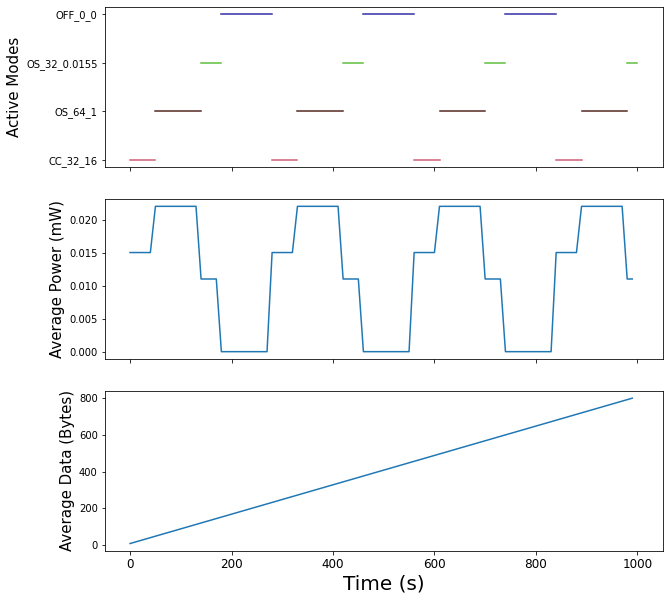

In [4]:
power_tmp, data_tmp, time_tmp= tmp.runSim(plot=True)

Beautiful! Feel free to play around with different lengths of each mode to see how the plot changes.  
Now that you have had a brief introduction, take care to read through the descriptions of each sensor then jump right in to making your own configuration!
***

# `Temperature Sensor Configurations`
### General Description:
* "The TMP117 is a high-precision digital temperature sensor"
* It provides a 16-bit temperature result with accuracy of up to $\pm 0.1 ^{\circ}C$ and resolution of $\pm 0.0078 ^{\circ}C$. 
* TMP117 has a programmable EEPROM (electrically erasable programmable read-only memory) and has 48-bits of memory available for general use  
  
* The selectable averaging option: allows users to configure the device to report the average of multiple temp. conversions. This means that the tmp sensor accumulates the conversion results and reports the average of all those results at the end of each conversion cycle. The possible averaging options are 0, 8, 32, or 64 averages.

| Modes | Description | Params |
|---|:---:|---|
| OS One-Shot Mode | After the device completes a one-shot conversion (temperature conversion), the device goes to the low-power shutdown mode.  For OS mode, the conv cycle time is the active time so the possible conv cycle times are only 0.0155, 0.125, 0.5, 1 since there is no standby. | Possible conversion cycle times: 0.0155, 0.125, 0.5, 1  Possible averaging inputs: 0, 8, 32, 64 |
| CC Continuous Conversion Mode | The device continuously performs temperature conversions in this mode, as shown in Table, and updates the temperature result register at the end of every active conversion.  The total conversion cycle includes the active conversion time and standby time. | Possible conversion cycle times: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16   Possible averaging inputs: 0, 8, 32, 64 |  

<center> <img src='convTimes.png' width="700" height="200">  

*Columns represent averaging: 0, 8, 32, 64 (left to right)*  
*Rows represent active conversion time: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16 (from top to bottom)*    
*The numbers inside the table itself represent the total conv cycle time* 

</center> 



For additional information:  
https://www.ti.com/lit/ds/symlink/tmp117.pdf?ts=1656974490603&ref_url=https%253A%252F%252Fwww.ti.com%252Ftechnologies%252Finternet-of-things%252Foverview.html 


#### TO-DO: Change parameters for TMP117 below

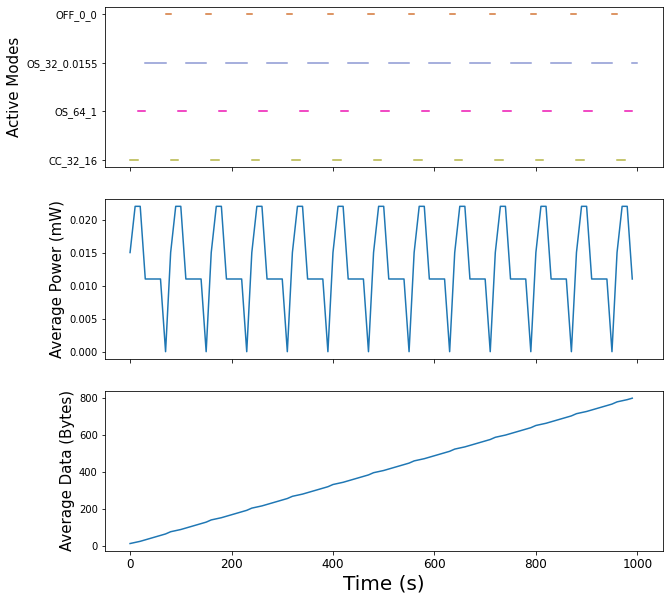

In [5]:
ModesTMP = np.array([("CC_32_16",15), ("OS_64_1",15), ("OS_32_0.0155",40), ("OFF_0_0",10)])
active_list = generateActiveList(duration, ModesTMP)
tmp = TMP117(time_step, duration, active_list, loop_rate = 20)
power_tmp, data_tmp, time_tmp= tmp.runSim(plot=True);

*** 

# `Accelerometer Configurations`

MPU6050 description:
- Gyroscope operating current: 3.6 mA
- Accelerometer operating current: 500 µA
    * Low power accelerometer mode current: 10µA at 1.25Hz, 20µA at 5Hz, 60µA at 20Hz, 110µA at
40Hz
- Everything enabled: 3.9 mA
- 16-bit registers for storing accelerometer/ gyroscope data, one per axis for each.
- 1024 byte FIFO buffer allowing reading/ writing data from registers.
- Temperature range is -40 to 85 °C

Modes:
The accelerometer has 9 different modes to choose from, with different capabilites, power usage, and data usage.

| Mode | Description | Power (mW) | Data (bytes/s) | Input string | Notes | 
|---|---|---|---|---|---| 
| Low power wakeup (x) | Wake the sensor to take a single accelerometer sample  at a given frequency given by x. Options include x=1.25, 5, 20, 40. | 0.033-0.462 | 7.5-640 | "low_power_wakeup_x" | Power and data increases with wakeup frequency. |
| Accelerometer only | Only use the accelerometer. | 1.65 | 6,000 | "accelerometer_only" | N/A | 
| Gyroscope only | Only use the gyroscope. | 11.88 | 48,000 | "gyroscope_only" | N/A |
| Accelerometer and Gyroscope | Both accelerometer and gyroscope. | 12.54 | 12,000 | "gyroscope_accelerometer" | The gyroscope and accelerometer take samples at different rates. The data value assumes a sample rate of the accelerometer, 1 kHz. | 
| Sleep | Does nothing. | 0.0165 | 0 | "sleep" | N/A |

*Power assumes a voltage of 3.3v, data assumes there are no bottlenecks such as loop rate.

Parameters:
- **digital low pass:** configures the digital low pass filter settings on the sensor. Setting digital_low_pass to 1 changes the output rate, 8kHz when 0 and 1kHz when 1.
- **sample rate divisor:** is a parameter to lower the sampling rate of the sensor. This value ranges from 0 to 255, and is used in the equation below.
    * Sample Rate = Gyroscope Output Rate / (1 + SMPLRT_DIV)
    * Note: gyroscope output rate changes if the digital low pass filter is on or not, 1kHz when on and 8kHz when off.
- **loop rate:** is a hypothetical bottleneck to the measuring rate of the sensor; it represents the loop rate of the LunaSat code.

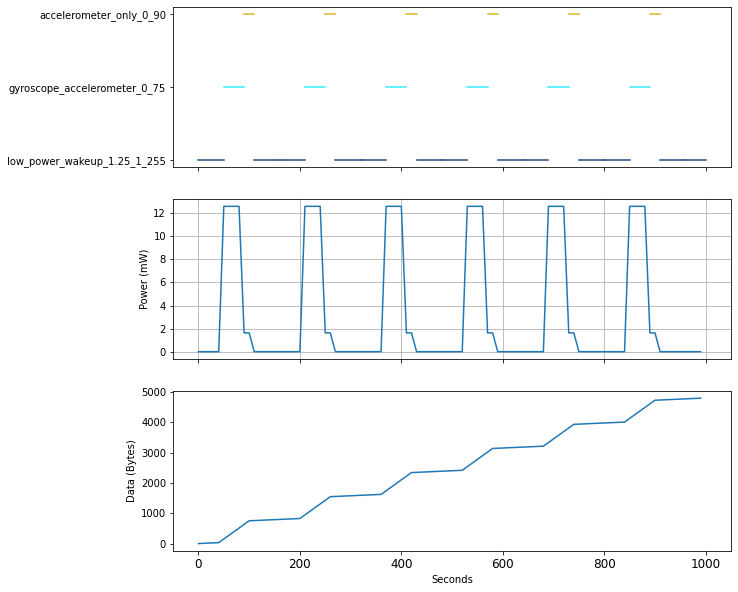

In [6]:
accelerometer = MPU6050(time_step=time_step, duration=duration, loop_rate=20)

#REMEBER TO TAKE OUT DMP FROM MODES. DMP IS CURSED AND WE DONT LIKE HIM.
ModesTMP = np.array([("low_power_wakeup_1.25_1_255",50), ("gyroscope_accelerometer_0_75",40), ("accelerometer_only_0_90", 20), ("low_power_wakeup_1.25_1_255",50)])
active_times = generateActiveList(total_time=duration, modelist=ModesTMP)
time_acc, power_acc, data_acc = accelerometer.runSim(active_times)

***

# `Thermopile Configurations`

The args we pass in to the function is the time_step and duration. As with the active times, we pass in what mode we want the sensro to run on as well as the times we want it to be active. The two possible modes are "TP_only" and "TP_off"

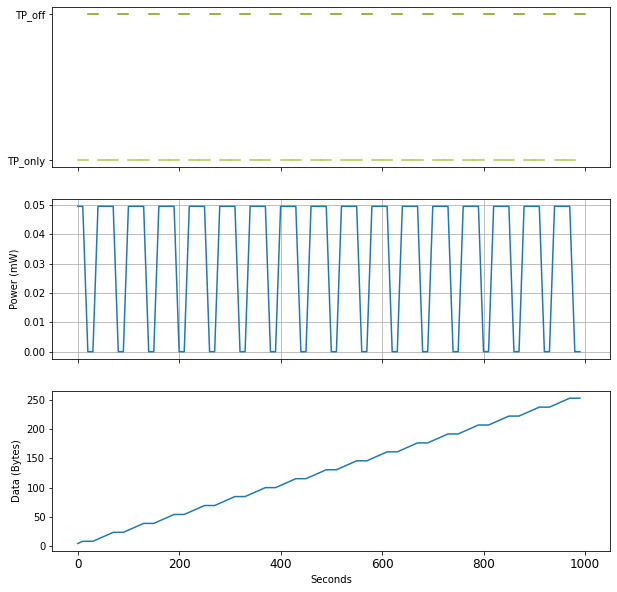

In [7]:
Thermo = TP(time_step, duration, loop_rate=20)
ModesThermo = np.array([("TP_only",20), ("TP_off",20), ("TP_only",20)])
active_times = generateActiveList(total_time=duration, modelist=ModesThermo)
tp_time, tp_power, tp_data = Thermo.runSim(active_times)

***

# `Capacitor Configurations`

CAP11NA description:
- We don't have a ton of info on this one. Citation needed?

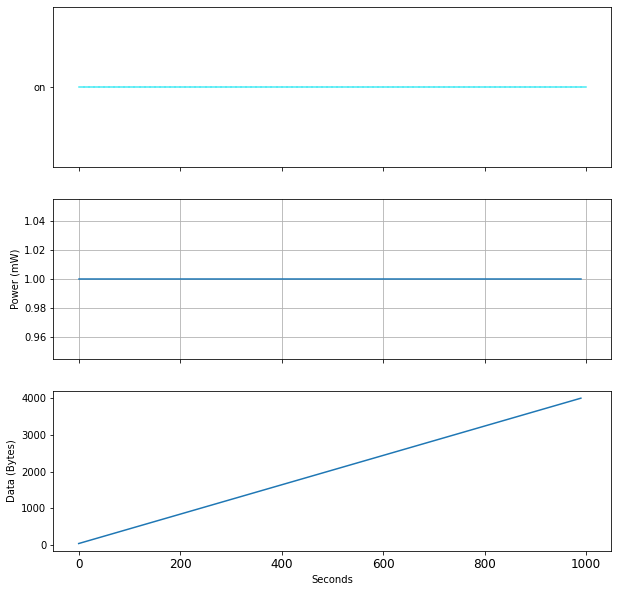

In [8]:
cap = CAP11NA(loop_rate=20, duration=duration, time_step=time_step)
ModesCapacitor = np.array([("on",10)]) #this means that it will always be on!
cap_active_times = generateActiveList(total_time=duration, modelist=ModesCapacitor)
cap_time, cap_power, cap_data = cap.runSim(cap_active_times)

***

# `Magnetometer Configurations`

BM1422 description:
- 0.15 mA operating current at 100SPS.
- Operating temperature -40 to 85 °C
- things?

Modes:
- The sensor supports different output rates for measuring, the options aer 10Hz, 20Hz, 100Hz, and 1kHz. These only change the amount of data collected, not the power. 
- There are continous and single modes, however the documentation for these is not great.


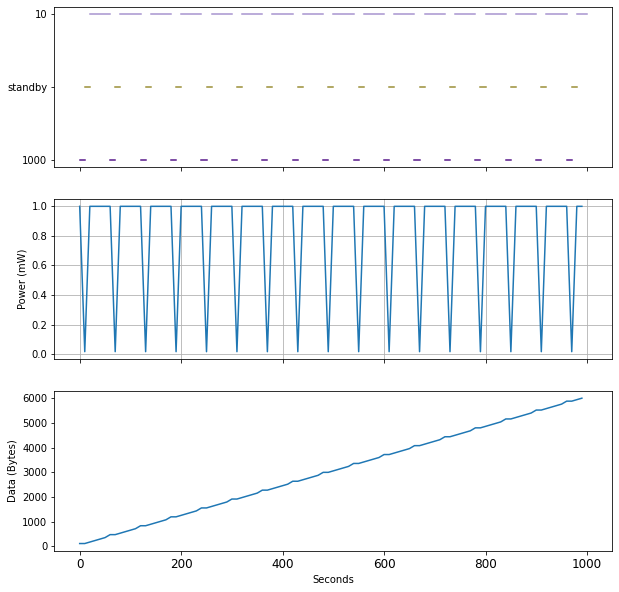

In [9]:
foo = BM1422(loop_rate=20, duration=duration, time_step=time_step)
#for magnetometer, the certain mode is the timing specification, or standby.
ModesMagnetometer = np.array([("1000",10), ("standby",10),("10",40)])
mag_activetimes = generateActiveList(total_time=duration, modelist=ModesMagnetometer)
mag_time, mag_power, mag_data = foo.runSim(mag_activetimes)

***

# `Solar Panel Model`

In [10]:
#power used by ATMega
chip_pow = 20

# `Solar Panel Model`

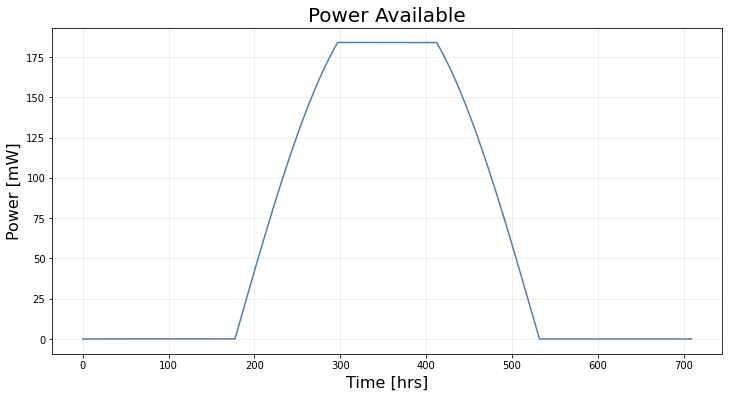

In [11]:
# the solar model plots the power available in a lunar day

solar_panel_model = SM141K(start_time_hrs=0, duration_hrs=709, time_step_seconds=30, latitude=45)
solar_panel_model.plotPowerAvailable()

***  
# `All Together`

In [12]:
total_pow = power_tmp + mag_power + power_acc + cap_power + tp_power + chip_pow
total_data = data_tmp + mag_data + data_acc + cap_data + tp_data #catherine broke main

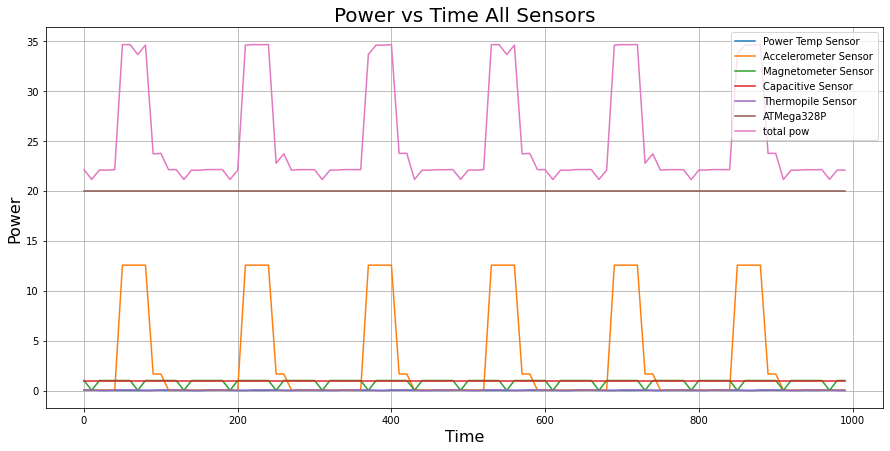

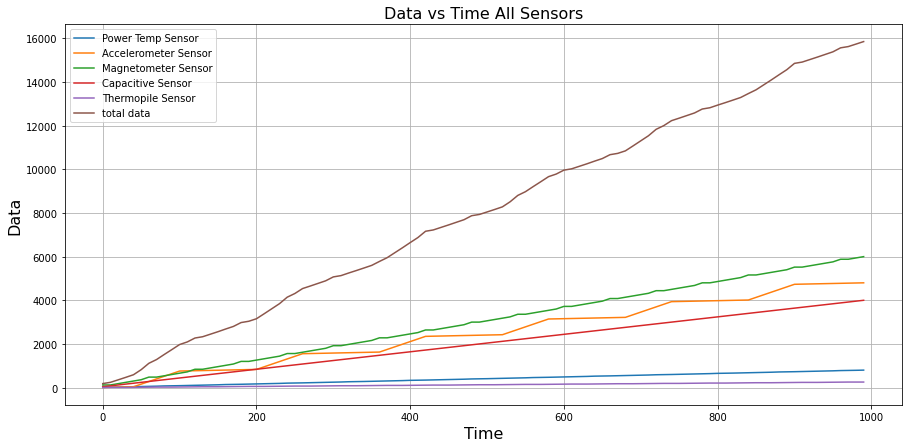

In [13]:
plotTogether(time_tmp, time_acc, tp_time, cap_time, mag_time, tp_power, power_tmp, power_acc, mag_power, cap_power, data_tmp, data_acc, mag_data, cap_data, tp_data, total_pow, total_data, chip_pow)


[195.85, 513.15]

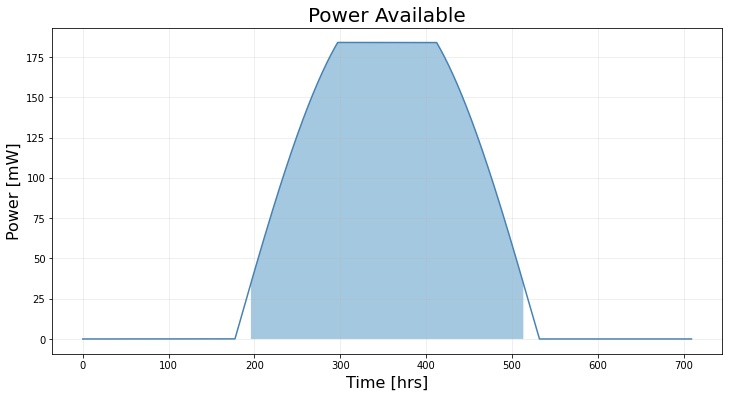

In [14]:
# The model shows the times in the shaded region where the solar panel produces enough power for the LunaSat with the given modes for each sensor

max_power_used = max(total_pow)
solar_panel_model.plotPowerAndTimesPossible(max_power = max_power_used)